## Dimensionality Reduction Tutorial: PCA on Hyperspectral Data
Hyperspectral images are images captured across a wide range of wavelengths, often hundreds of narrow spectral bands, beyond what the human eye can see. Unlike regular RGB images that use three color bands (red, green, blue), hyperspectral images provide detailed spectral information for each pixel.
They are used in agriculture, environmental monitoring, mineral exploration, surveillance, and medical imaging to identify and analyze materials accurately.

In this tutorial, we will use **Principal Component Analysis (PCA)** for dimensionality reduction on hyperspectral imagery, followed by classification using a **Random Forest**.

---

### Introduction

Hyperspectral images contain hundreds of spectral bands per pixel, resulting in high-dimensional data. Processing and visualizing such data can be challenging due to the **curse of dimensionality**. PCA helps by transforming the data into a lower-dimensional space that retains most of the variance.

**Applications**:

* Preprocessing for classification and clustering
* Visualization of high-dimensional data
* Noise reduction and data compression

---

### 1. Load and Prepare Data

We load the Salinas Valley hyperspectral dataset (MATLAB files) and reshape it into a 2D table where each row is a pixel and each column a spectral band.
[Here](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Salinas) you can find more information about the data source.

In [1]:
import numpy as np
import pandas as pd
import scipy.io

# Read MATLAB file and flatten the image
img = scipy.io.loadmat('dimensionality_dataset_X.mat')['salinas_corrected']  # (rows, cols, bands)
num_bands = img.shape[-1]
flat_img = img.reshape(-1, num_bands)  # flatten to (pixels, bands)
X = pd.DataFrame(flat_img, columns=range(num_bands))  # DataFrame of band values

# Load ground truth labels
y = scipy.io.loadmat('dimensionality_dataset_groundtruth.mat')['salinas_gt'].flatten()

print(X.head())  # inspect first rows

   0    1    2     3     4     5     6     7     8     9    ...  194  195  \
0  290  381  585  1041  1316  1397  1319  1462  1643  1683  ...  104   96   
1  290  381  519  1041  1316  1352  1319  1462  1643  1683  ...  111   94   
2  290  381  585  1041  1286  1352  1300  1412  1614  1644  ...  106   88   
3  290  381  585   999  1316  1374  1280  1380  1584  1631  ...  100   86   
4  219  381  585   999  1286  1352  1261  1396  1555  1618  ...   96   83   

   196  197  198  199  200  201  202  203  
0  109   93   54   79   54   36   11   17  
1  111   96   56   83   56   36   11   15  
2  107   89   54   81   54   30   11   11  
3  105   85   56   75   50   30   11   19  
4  105   83   48   75   50   24    9   17  

[5 rows x 204 columns]


*Comments*: We structure the data for modeling, preserving all spectral bands.

---

### 2. PCA for Variance Retention

We apply PCA to retain 99% of the variance, reducing dimensionality significantly.

In [2]:
from sklearn.decomposition import PCA

# Apply PCA to retain 99% of variance
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

print('Original dimensions:', X.shape[1])
print('Reduced dimensions:', pca.n_components_)

Original dimensions: 204
Reduced dimensions: 3


*Explanation*: PCA projects data onto orthogonal axes (principal components) sorted by explained variance. Here, only the top \~3 components are needed to capture 99% variance.

---

### 3. Classification with Random Forest

We compare performance of a Random Forest classifier on raw vs. PCA-transformed data.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#original data
clf_orig = RandomForestClassifier()
clf_orig.fit(X_train, y_train)
acc_orig = f1_score(y_test, clf_orig.predict(X_test), average='macro') #f1 due to high class imbalance (Gini 0.83)
#reduced data
clf_pca = RandomForestClassifier()
clf_pca.fit(X_train_pca, y_train)
acc_pca = f1_score(y_test, clf_pca.predict(X_test_pca), average='macro')

print('Original f1:',acc_orig)
print('PCA-reduced f1:',acc_pca)

Original f1: 0.9159342884578576
PCA-reduced f1: 0.8619499164225496


The f1-score of the classifier with the original data is at 0.91, and only slightly higher than the PCA-reduced one at 0.86.
Thus, the dimensionality reduction speeds up the training with a minimal loss in accuracy!

---

### 4. Visualizing Clusters in 2D

To interpret class separability, we visualize the first two principal components. Due to class imbalance, we undersample minority classes.

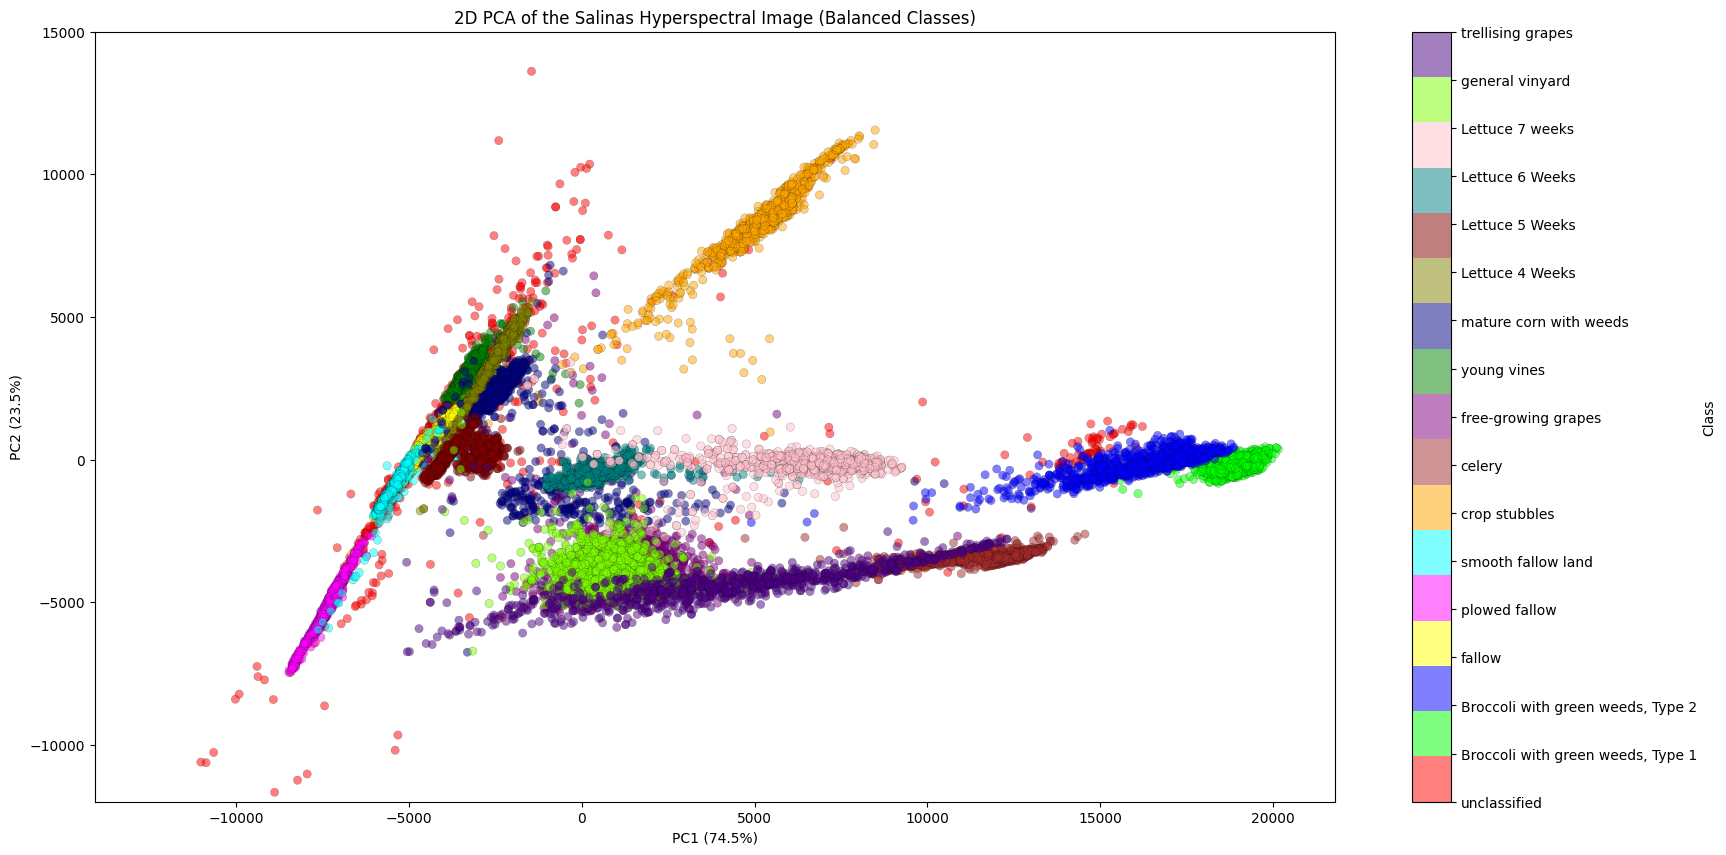

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X)

rus = RandomUnderSampler()
X_vis_balanced, y_vis_balanced = rus.fit_resample(X_vis, y)

plt.figure(figsize=(20, 10))

#manual color mapping because all available cmaps made the classes difficult to distinguish visually!
manual_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00',  # Red, Green, Blue, Yellow
    '#FF00FF', '#00FFFF', '#FFA500', '#A52A2A',  # Magenta, Cyan, Orange, Brown
    '#800080', '#008000', '#000080', '#808000',  # Purple, Dark Green, Navy, Olive
    '#800000', '#008080', '#FFC0CB', '#7CFC00', '#4B0082'] # Maroon, Teal, Pink, Lawn Green, Indigo

cmap = ListedColormap(manual_colors)
classes = np.unique(y_vis_balanced)
colors = [cmap(i / len(classes)) for i in range(len(classes))]
scatter = plt.scatter(X_vis_balanced[:, 0], X_vis_balanced[:, 1], c=y_vis_balanced, cmap=cmap, alpha=0.5,
    edgecolor='k',linewidth=0.2)
cbar = plt.colorbar(scatter, ticks=classes, label='Class')
class_names = ['unclassified','Broccoli with green weeds, Type 1',
'Broccoli with green weeds, Type 2',
'fallow','plowed fallow','smooth fallow land','crop stubbles','celery','free-growing grapes',
'young vines','mature corn with weeds','Lettuce 4 Weeks','Lettuce 5 Weeks','Lettuce 6 Weeks','Lettuce 7 weeks',
'general vinyard','trellising grapes']
cbar.set_ticklabels(class_names)

plt.xlabel(f'PC1 ({round(pca_vis.explained_variance_ratio_[0] * 100, 1)}%)')
plt.ylabel(f'PC2 ({round(pca_vis.explained_variance_ratio_[1] * 100, 1)}%)')
plt.ylim((-12000, 15000)) #not plotting 2-3 unclassified outliers
plt.title('2D PCA of the Salinas Hyperspectral Image (Balanced Classes)')
plt.show()

*Interpretation*: Clusters show how different land cover types separate in the reduced space.

---

### Conclusion and Next Steps

* **PCA** effectively reduces dimensions, retaining most variance.
* **Random Forest** on PCA data can match original accuracy with faster computation.
* **Visualization** aids interpretability of complex data.